# I. Import the libraries/dataset

In [40]:
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import joblib

#Scikit learn models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.ensemble import GradientBoostingClassifier

# Evaluate the model
from sklearn.metrics import classification_report,f1_score,precision_recall_fscore_support


In [2]:
df_train = pd.read_csv("dataset/sat.trn", sep = " ",header=None)
df_test = pd.read_csv("dataset/sat.tst", sep = " ",header=None)

In [3]:
df_train_central = pd.concat([df_train.iloc[:,17:21], df_train.iloc[:,36]],axis=1)
df_test_central = pd.concat([df_test.iloc[:,17:21], df_test.iloc[:,36]],axis=1)

# II. Data exploration

## 1. Contenu du dataset

- La base de donnée consiste a des  valeurs multi spectrale de pixels dans une image satellite. La classe à prédire et le pixel central dans chaque groupe de voisins. La classe à prédire à été transformé et pour des raisons de facilité à des valeurs entre 1 et 7.
Nous avons 4435 valeurs dans le training set et 2000 dans le testing set.

- Chaque image prise par le satellite landsat consiste en 4 différentes images de la meme scène mais prise dans des valeurs spectrales différentes (2 dans le domaine du visible et 2 dans l'infrarouge). Chaque image à une résolution de 2340 x 3380 

- Dans notre dataset, on à une petite partie de l'image (82 x 100 pixels) 

Sur le schéma ci-dessous nous aovns représenté 1 ligne du dataframe. La ligne répresente en fait 1 pixel (rouge) qu'on cherche à prédire, ainsi que ces voisins. Comme on peut le voir les pixels sont mis à la ligne les uns a la suite des autres, et chaque pixels est représenté par 4 valeurs entre 0 et 255.
C'est un problème de multi classififcation, le but étant de savoir si le pixel de l'image, correspond à de la terre grise, rouge ou des vegetaux etc...

![Getting Started](pixels.png)

### Pour prédire la classe on peut soit prendre tous les pixels (pixels 1 à 9 sur le schéma), soit prendre uniquement les pixels à prédire (pixel 5 sur le schéma). Nous avons réalisé des modèles dans les 2 cas. En revanche pour l'api, nous avons seulement pris le modèle 2 qui prend en paramètre le pixel à prédire pour plus de simplicité.

## 2. Classe à prédire

Tout d'abord en regardant les labels, et le nombre dans chaque classe, on se rend compte que elles ne sont pas bien répartis ce qui peut poser plusieurs problèmes
- L'accuracy n'est forcément pas une bonne metrics pour vérifier notre classification 

Nous allons donc utiliser d'autres metrics pour vérifier la prédiction de notre algortihme 
- confusion matrix 
- score F1 (qui est une moyenne de la précision et du rappel) 

## 3. Data visualisation 

- Notre dataset est constitué de pixels, nous allons donc regarder la distribution des pixels de notre dataset. On peut voir dans le graphique ci-dessous que la distribution des pixels n'est pas uniforme. En effet la distriution des pixels à une forme gausienne.

- Ensuite nous avons regardé la distribution des classes dans notre dataset. Dans la 2ème visualisation nous pouvons voir que la classe 6 ne possède 0 valeurs, nous allons donc la supprimer.

In [4]:
dicto = dict()

def get_dict(x):
    #if dicto[x]:
    if x in dicto:
        dicto[x] +=1
    else:
        dicto[x] =1
    return x

for i in range(0,35,1): 
    df_test.iloc[:,i].apply(lambda x : get_dict(x))

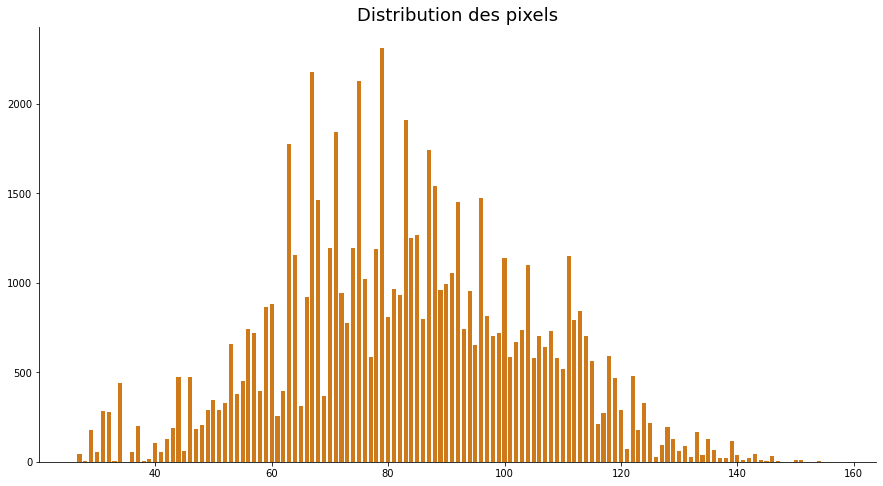

In [7]:
fig, ax = plt.subplots(1,figsize=(15,8))
ax.bar(dicto.keys(), dicto.values(),width=0.7, color='#CE7A1B')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Distribution des pixels',fontsize = 18)
fig.show()

In [158]:
def plot(df):
    index =  df.iloc[:,36].value_counts().index.to_list()
    count = df.iloc[:,36].value_counts().to_list()
    count.append(0)
    index.append(0)
    count_df = df.iloc[:,36].value_counts().to_frame()
    count_df.loc[6]= 0
    count_df.sort_index(inplace = True)
    bins_label = ["1. red soil","2. cotton crop","3. grey soil","4. damp grey soil","5. soil with vegetation stubble","mixture class (all types present)","7. very damp grey soil"]
    count_df["labels"] = bins_label

    fig = px.bar(count_df, x=bins_label, y=36,title="Distribution des classes à prédire")
    fig.show()

plot(df_train)

In [159]:
def line_plot(x,y,title):
    fig = px.line( x=x, y=y, title=title)
    fig.show()

# III. Models

On définit le la matrice test x pour les valeurs et y pour les labels

In [8]:
df_train[df_train.iloc[:,36] == 7] = 6 
df_test[df_test.iloc[:,36] == 7] = 6 


df_train_central[df_train_central.iloc[:,4] == 7] = 6 
df_test_central[df_test_central.iloc[:,4] == 7] = 6 

In [9]:
x_train = df_train.iloc[:,:36]
y_train = df_train.iloc[:,36]

x_test = df_test.iloc[:,:36]
y_test = df_test.iloc[:,36]

In [10]:
x_train_central = df_train_central.iloc[:,:4]
y_train_central = df_train_central.iloc[:,4]

x_test_central = df_test_central.iloc[:,:4]
y_test_central = df_test_central.iloc[:,4]

Nous allons tester plusieurs modèles pour répondre à ce problème, et compararer les résultats entre eux.

In [20]:
f1_score_weighted_avg = []
algo_used = []

## 1. KNN

In [188]:
list_scores = []
for i in range(1,50,1):
    knn = KNeighborsClassifier(n_neighbors=i, metric='euclidean')
    knn.fit(x_train,y_train)
    y_pred = knn.predict(x_test)

    score = f1_score(y_test,y_pred, average='weighted')
    list_scores.append(score)

In [170]:
line_plot(range(1,50),list_scores,"Numbers of neighbors")

In [21]:
algo_used.append("KNN")

knn = KNeighborsClassifier(n_neighbors=7, metric='euclidean')
knn.fit(x_train,y_train)
y_pred = knn.predict(x_test)
score = f1_score(y_test,y_pred, average='weighted')
f1_score_weighted_avg.append(round(score,3))
f1_score_weighted_avg

[0.959]

## 2. Random Forest

On va maintenant utiliser le random Forest pour essayer d'augmenter la classification.
En faisant varier le nombre d'arbres, ainsi que la profondeur de chaque arbre et le nombre de split minimum on va essayer de trouver le random forest qui nous donne la meilleur accuracy

In [38]:
#test 1 : n_estimators(1,200) opt = 50
list_scores = []

n_estimators = 200
for i in range(1,n_estimators):
    clf = RandomForestClassifier(n_estimators = i)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)

    score = f1_score(y_test,y_pred, average='weighted')
    list_scores.append(score)

In [43]:
line_plot(range(1,200),list_scores,"Numbers of tree")

In [44]:
#test 1 : max_depth(0,200) opt 30
list_scores = []

max_depth = 200
for i in range(1,max_depth):
    clf = RandomForestClassifier(n_estimators = 50,max_depth=i)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)

    score = f1_score(y_test,y_pred, average='weighted')
    list_scores.append(score)

In [46]:
line_plot(range(1,200),list_scores,"Max depth of each tree")

In [47]:
#test 1 : min split(0,200) opt 3

list_scores = []

min_samples_split = 50
for i in range(2,min_samples_split):
    clf = RandomForestClassifier(n_estimators = 50,max_depth=30,min_samples_split = i)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)

    score = f1_score(y_test,y_pred, average='weighted')
    list_scores.append(score)

In [49]:
line_plot(range(2,50),list_scores,"Minimu number of sample to split")

Apres avoir fait les testsn on va utiliser 50 arbres, une profondeur de 30 et un nombre minimum de split de 3

In [23]:
algo_used.append("Random Forest")

clf = RandomForestClassifier(n_estimators = 50,max_depth=30,min_samples_split = 3)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

score = f1_score(y_test,y_pred, average='weighted')

f1_score_weighted_avg.append(round(score,3))
f1_score_weighted_avg

[0.959, 0.958]

On a amelioré l'accuracy de 0.93 a 0.96. Voyons voir si avec un gradient boosting on peut encore améliorer notre prédiction.

### 5. Gradient boosting

In [ ]:
#test 1 : n_estimators(1,200) opt = 71
list_scores = []

n_estimators = 1000
for i in range(1,n_estimators,10):
    clf = GradientBoostingClassifier(n_estimators=i).fit(x_train, y_train)
    y_pred = clf.predict(x_test)

    score = f1_score(y_test,y_pred, average='weighted')
    list_scores.append(score)

In [82]:
line_plot(range(1,592,10),list_scores,"Numbers of tree")

In [ ]:
#test 1 : n_estimators(1,200) opt = 71
list_scores = []

n_estimators = 200
for i in range(1,200):
    clf = GradientBoostingClassifier(n_estimators=i, learning_rate=1.0,
    max_depth=1, random_state=0).fit(x_train, y_train)
    y_pred = clf.predict(x_test)

    score = f1_score(y_test,y_pred, average='weighted')
    list_scores.append(score)

In [28]:
grid = dict()
grid['n_estimators'] = [10, 50, 100, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
grid['subsample'] = [0.5, 0.7, 1.0]
grid['max_depth'] = [3, 7, 9]
grid

{'n_estimators': [10, 50, 100, 500],
 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
 'subsample': [0.5, 0.7, 1.0],
 'max_depth': [3, 7, 9]}

In [99]:
model = GradientBoostingClassifier()
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, scoring='accuracy')

In [100]:
grid_result = grid_search.fit(x_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#Best: 0.922210 using {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.7}

Best: 0.922210 using {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.7}


In [25]:
#algo_used = []

algo_used.append("Gradient Boosting")

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=7, random_state=0,subsample=0.7).fit(x_train,y_train)
y_pred = clf.predict(x_test)
score = f1_score(y_test,y_pred, average='weighted')

f1_score_weighted_avg.append(round(score,3))
f1_score_weighted_avg

[0.959, 0.958, 0.956]

# Results of the models

In [26]:
#dictonary = {}
df = pd.DataFrame(list(zip(f1_score_weighted_avg,algo_used)),columns =["F1 score","Models"])
df

,F1 score,Models
0,0.959,KNN
1,0.958,Random Forest
2,0.956,Gradient Boosting


In [221]:
algo_used

['KNN', 'Random Forest', 'Gradient Boosting']

In [ ]:
fig,(ax1) = plt.subplots(figsize=(10,5))
fig.tight_layout()

#fig, axs = plt.subplots(1, 2,figsize=(10,5))
ax1.bar(["real","predictions"],pos,color='#c3d5e8',width=0.5)
ax1.set_xlabel("positives")
ax1.set(frame_on=False)

#ax1.set_ylim(0,1100)
#ax1.set_xticklabels(labels =["real","predictions"], rotation=0)

#for i in range(len(pos)):
  #ax1.text(x = i -0.05, y = pos[i]+15, s = pos[i], size = 8)

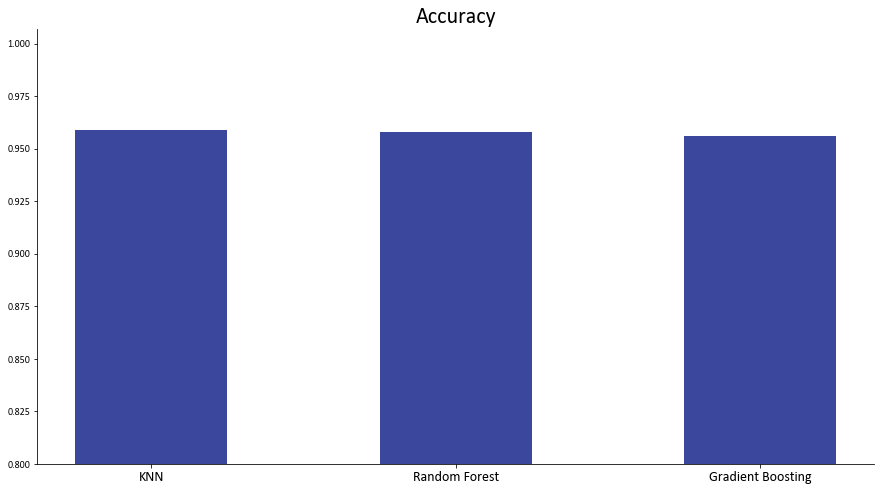

In [38]:
fig, ax = plt.subplots(1,figsize=(15,8))
ax.bar(df["Models"], df["F1 score"],width=0.5, color='#3B479D')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('Accuracy',fontsize = 22,fontname="Calibri")
ax.set_ylim(ymin=0.8)
plt.xticks(fontsize=14,fontname="Calibri")
plt.yticks(fontsize=10,fontname="Calibri")
fig.show()

In [ ]:
line_plot(algo_used,list_scores,"F1 score")

## Save the model to use it in the api

In [45]:
joblib.dump(clf,"gradient_boosting.pkl")

['gradient_boosting.pkl']

In [46]:
joblib.load("gradient_boosting.pkl")

GradientBoostingClassifier(max_depth=7, random_state=0, subsample=0.7)